# 라이브러리 호출

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from cliffs_delta import cliffs_delta
from scipy.stats import mannwhitneyu, shapiro

# 3년 생존률 포함 버전 점수 생성 및 검증

In [29]:
# 파일 경로
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192_최종.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="utf-8")

# 2024년 2분기 데이터 필터링
df = df[df['연분기'] == 20242]

# 사용할 특성(변수) 목록
features = ['1년생존률', '3년생존률', '5년생존률', '프랜차이즈_변동성', '매출_건수_변동성', '폐업-개업 비율', '유동인구당 점포수']

# 데이터 타입 변환 (숫자로 변환, 변환 불가능한 값은 NaN 처리)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# 상권별 평균값 계산
df_selected = df[['상권명'] + features].groupby('상권명')[features].mean().reset_index()

# 결측치(NaN) 처리: 중앙값으로 대체
df_selected[features] = df_selected[features].fillna(df_selected[features].median())

# 변동성 관련 변수 반전 (값이 작을수록 점수가 높아지도록)
inverse_features = ['프랜차이즈_변동성', '매출_건수_변동성', '폐업-개업 비율']
df_selected[inverse_features] = -df_selected[inverse_features]

# 표준화 (Z-score 변환)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# PCA 수행 (주성분 2개 선택)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_

# 주성분 가중 평균 계산
weighted_pca_score = (pca_result[:, 0] * explained_variance[0]) + (pca_result[:, 1] * explained_variance[1])
weighted_pca_score = weighted_pca_score.reshape(-1, 1)

# Min-Max 스케일링 (0~20 범위)
minmax_scaler = MinMaxScaler(feature_range=(0, 20))
final_scores = minmax_scaler.fit_transform(weighted_pca_score)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권명': df_selected['상권명'],
    '안정성_점수': final_scores.flatten()
})

# 안정성 점수 기준 내림차순 정렬
result_df = result_df.sort_values('안정성_점수', ascending=False)

# 출력
print(result_df)

                   상권명     안정성_점수
386             신풍역 2번  20.000000
172  마전교지하쇼핑센터(구 한일상가)  19.455591
84               금천파출소  19.217263
575             회현역 1번  19.130722
115            답십리역 6번  19.077182
..                 ...        ...
69    구립대학경로당(관악산샘말공원)   1.224069
234                불광역   0.805528
24                 개롱역   0.748197
517             창신골목시장   0.520811
336   수유중앙골목시장(수유중앙시장)   0.000000

[579 rows x 2 columns]


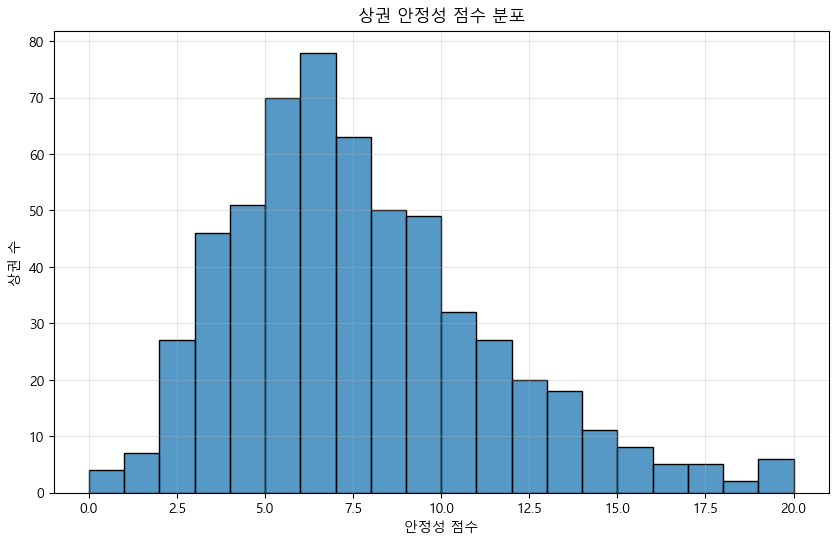

In [17]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='안정성_점수', bins=20)

# 그래프 제목과 축 레이블 설정
plt.title('상권 안정성 점수 분포')
plt.xlabel('안정성 점수')
plt.ylabel('상권 수')

# 그리드 추가
plt.grid(True, alpha=0.3)

plt.show()

In [19]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")

주성분 1: 설명된 분산 비율 = 0.2959
주성분 2: 설명된 분산 비율 = 0.1713


🔍 주성분과 원래 변수 간의 상관관계:
                PC1       PC2
프랜차이즈_변동성  0.724836  0.216296
개폐업_균형_지수  0.060654 -0.397220
매출_금액_변동성  0.838375  0.144185
매출_건수_변동성  0.891469  0.129990
3년생존률     -0.224364  0.666140
5년생존률     -0.320257  0.686923


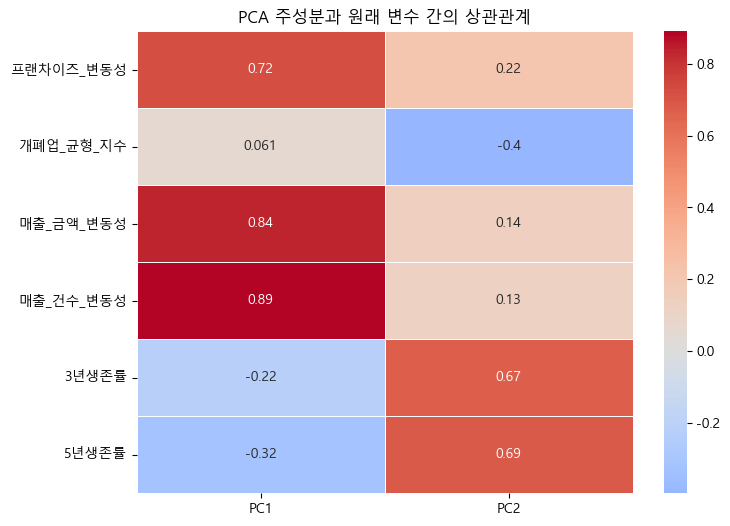

In [20]:
# 파일 경로
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192_최종.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="utf-8")

# 2024년 2분기 데이터 필터링
df = df[df['연분기'] == 20242]

# 사용할 특성(변수) 목록
features = ['프랜차이즈_변동성', '개폐업_균형_지수', '매출_금액_변동성', '매출_건수_변동성', '3년생존률', '5년생존률']

# 데이터 타입 변환 (숫자로 변환, 변환 불가능한 값은 NaN 처리)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# 상권별 평균값 계산
df_selected = df[['상권명'] + features].groupby('상권명')[features].mean().reset_index()

# 결측치(NaN) 처리: 중앙값으로 대체
df_selected[features] = df_selected[features].fillna(df_selected[features].median())

# 표준화 (Z-score 변환)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# PCA 수행 (주성분 2개 선택)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# 원래 데이터와 주성분 간의 상관관계 계산
correlation_matrix_pc1 = pd.DataFrame(scaled_features, columns=features).corrwith(pca_df['PC1'])
correlation_matrix_pc2 = pd.DataFrame(scaled_features, columns=features).corrwith(pca_df['PC2'])

# 상관관계 결과 합치기
correlation_df = pd.DataFrame({
    'PC1': correlation_matrix_pc1,
    'PC2': correlation_matrix_pc2
})

# 결과 출력
print("🔍 주성분과 원래 변수 간의 상관관계:")
print(correlation_df)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("PCA 주성분과 원래 변수 간의 상관관계")
plt.show()

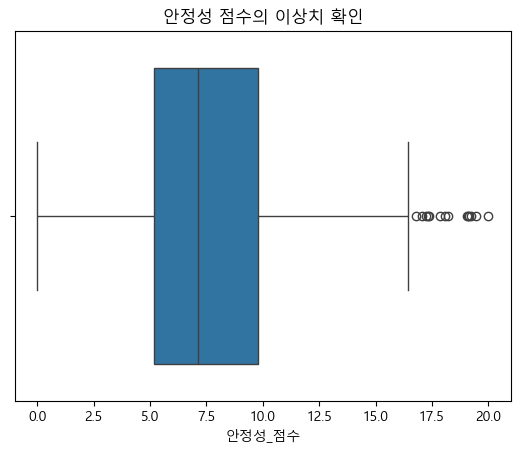

In [21]:
sns.boxplot(x=result_df['안정성_점수'])
plt.title("안정성 점수의 이상치 확인")
plt.show()

In [22]:
# 안정성 기준 설정 (상위 35%를 안정으로 분류)
threshold = result_df['안정성_점수'].quantile(0.65)  # 65% 지점(하위 65%)

# 안정(35%) / 불안정(65%) 분류
result_df['분류'] = result_df['안정성_점수'].apply(lambda x: '안정' if x >= threshold else '불안정')

# 실제 분포 확인
print(result_df['분류'].value_counts(normalize=True))

분류
불안정    0.649396
안정     0.350604
Name: proportion, dtype: float64


In [30]:
# 안정성 점수와 폐업률 간의 상관관계 계산
real_data = df_selected[['상권명', '3년생존률']]  # 실제 생존률 데이터
merged_df = result_df.merge(real_data, on='상권명')

correlation = merged_df['안정성_점수'].corr(merged_df['3년생존률'])
print("안정성 점수와 실제 생존률 간의 상관계수:", correlation)

안정성 점수와 실제 생존률 간의 상관계수: 0.5244400401723934


# 3년 생존률 제외 버전 점수 생성 및 검증

In [37]:
# 파일 경로
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192_최종.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="utf-8")

# 2024년 2분기 데이터 필터링
df = df[df['연분기'] == 20242]

# 사용할 특성(변수) 목록
features = ['1년생존률', '5년생존률', '프랜차이즈_변동성', '매출_건수_변동성', '폐업-개업 비율', '유동인구당 점포수']

# 데이터 타입 변환 (숫자로 변환, 변환 불가능한 값은 NaN 처리)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# 상권별 평균값 계산
df_selected = df[['상권명'] + features].groupby('상권명')[features].mean().reset_index()

# 결측치(NaN) 처리: 중앙값으로 대체
df_selected[features] = df_selected[features].fillna(df_selected[features].median())

# 변동성 관련 변수 반전 (값이 작을수록 점수가 높아지도록)
inverse_features = ['프랜차이즈_변동성', '매출_건수_변동성', '폐업-개업 비율', '유동인구당 점포수']
df_selected[inverse_features] = -df_selected[inverse_features]

# 표준화 (Z-score 변환)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# PCA 수행 (주성분 2개 선택)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_

# 주성분 가중 평균 계산
weighted_pca_score = (pca_result[:, 0] * explained_variance[0]) + (pca_result[:, 1] * explained_variance[1])
weighted_pca_score = weighted_pca_score.reshape(-1, 1)

# Min-Max 스케일링 (0~20 범위)
minmax_scaler = MinMaxScaler(feature_range=(0, 20))
final_scores = minmax_scaler.fit_transform(weighted_pca_score)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권명': df_selected['상권명'],
    '안정성_점수': final_scores.flatten()
})

# 안정성 점수 기준 내림차순 정렬
result_df = result_df.sort_values('안정성_점수', ascending=False)

# 출력
print(result_df)

                 상권명     안정성_점수
25           개미어린이공원  20.000000
573          황학동벼룩시장  18.866837
115          답십리역 6번  18.121806
321          솔숲어린이공원  17.711955
386           신풍역 2번  17.294951
..               ...        ...
45        경희대학교(경희대)   0.444050
466  이화여대 3,5,7길 상점가   0.375021
375         신월3동주민센터   0.142803
24               개롱역   0.096545
234              불광역   0.000000

[579 rows x 2 columns]


## 검증 부분

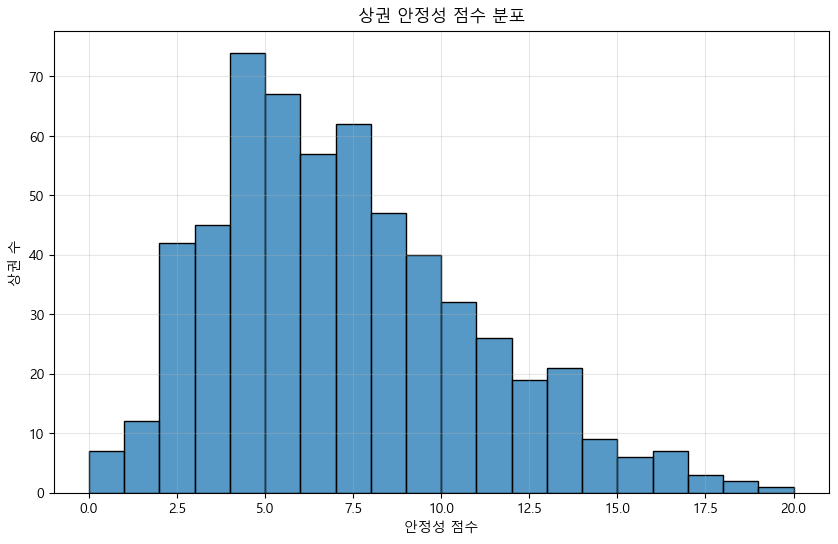

In [54]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='안정성_점수', bins=20)

# 그래프 제목과 축 레이블 설정
plt.title('상권 안정성 점수 분포')
plt.xlabel('안정성 점수')
plt.ylabel('상권 수')

# 그리드 추가
plt.grid(True, alpha=0.3)

plt.show()

In [56]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")

주성분 1: 설명된 분산 비율 = 0.3393
주성분 2: 설명된 분산 비율 = 0.1706


🔍 주성분과 원래 변수 간의 상관관계:
                PC1       PC2
1년생존률     -0.353480  0.594723
5년생존률     -0.273987  0.732595
프랜차이즈_변동성  0.723557  0.225572
매출_건수_변동성  0.820817  0.052156
폐업-개업 비율   0.628796  0.129319
유동인구당 점포수  0.493158  0.250637


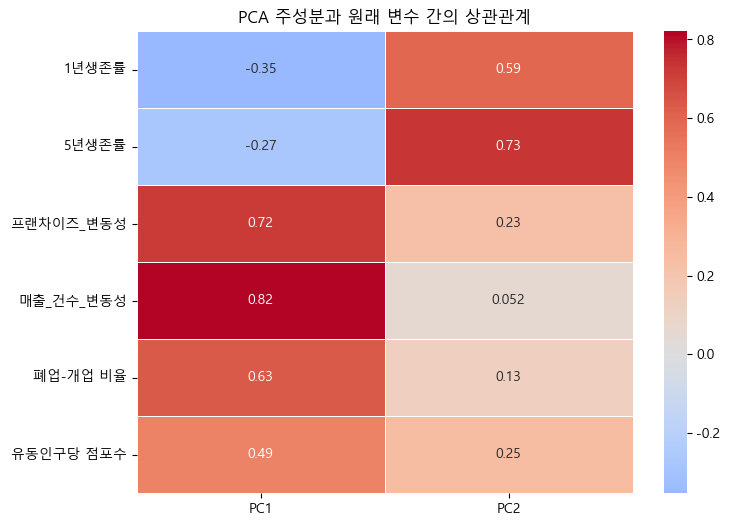

In [57]:
# 파일 경로
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192_최종.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="utf-8")

# 2024년 2분기 데이터 필터링
df = df[df['연분기'] == 20242]

# 사용할 특성(변수) 목록
features = ['1년생존률', '5년생존률', '프랜차이즈_변동성', '매출_건수_변동성', '폐업-개업 비율', '유동인구당 점포수']

# 데이터 타입 변환 (숫자로 변환, 변환 불가능한 값은 NaN 처리)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# 상권별 평균값 계산
df_selected = df[['상권명'] + features].groupby('상권명')[features].mean().reset_index()

# 결측치(NaN) 처리: 중앙값으로 대체
df_selected[features] = df_selected[features].fillna(df_selected[features].median())

# 표준화 (Z-score 변환)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# PCA 수행 (주성분 2개 선택)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# 원래 데이터와 주성분 간의 상관관계 계산
correlation_matrix_pc1 = pd.DataFrame(scaled_features, columns=features).corrwith(pca_df['PC1'])
correlation_matrix_pc2 = pd.DataFrame(scaled_features, columns=features).corrwith(pca_df['PC2'])

# 상관관계 결과 합치기
correlation_df = pd.DataFrame({
    'PC1': correlation_matrix_pc1,
    'PC2': correlation_matrix_pc2
})

# 결과 출력
print("🔍 주성분과 원래 변수 간의 상관관계:")
print(correlation_df)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("PCA 주성분과 원래 변수 간의 상관관계")
plt.show()

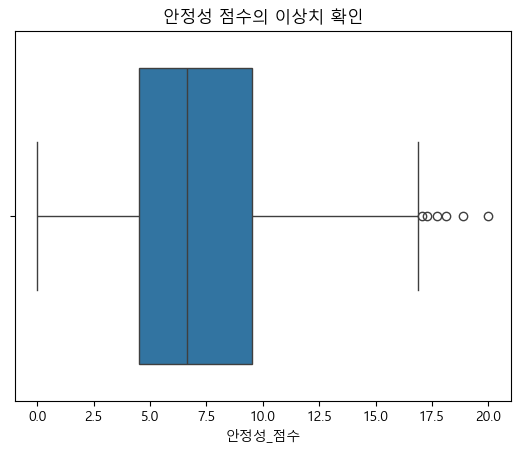

In [58]:
sns.boxplot(x=result_df['안정성_점수'])
plt.title("안정성 점수의 이상치 확인")
plt.show()

In [60]:
# 안정성 점수와 폐업률 간의 상관관계 계산
real_data = df[['상권명', '3년생존률']].drop_duplicates()
merged_df = result_df.merge(real_data, on='상권명', how='left')

correlation = merged_df['안정성_점수'].corr(merged_df['3년생존률'])
print("안정성 점수와 실제 생존률 간의 상관계수:", correlation)

안정성 점수와 실제 생존률 간의 상관계수: 0.19505026232554643


In [64]:
df_sales = pd.read_csv(r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192_최종.csv")
correlation = df_sales["유동인구당 점포수"].corr(df_sales["3년생존률"])
print("유동인구당 점포수와 안정성 점수의 상관계수:", correlation)

유동인구당 점포수와 안정성 점수의 상관계수: -0.04889469337241235


# 최종 결정 - 3년 생존률 제거 버전 점수 생성 및 저장

In [65]:
# 파일 경로
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192_최종.csv"
output_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192_최종_안정성추가.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="utf-8")

# 2024년 2분기 데이터 필터링
df = df[df['연분기'] == 20242]

# 사용할 특성(변수) 목록
features = ['1년생존률', '5년생존률', '프랜차이즈_변동성', '매출_건수_변동성', '폐업-개업 비율', '유동인구당 점포수']

# 데이터 타입 변환 (숫자로 변환, 변환 불가능한 값은 NaN 처리)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# 상권별 평균값 계산
df_selected = df[['상권명'] + features].groupby('상권명')[features].mean().reset_index()

# 결측치(NaN) 처리: 중앙값으로 대체
df_selected[features] = df_selected[features].fillna(df_selected[features].median())

# 변동성 관련 변수 반전 (값이 작을수록 점수가 높아지도록)
inverse_features = ['프랜차이즈_변동성', '매출_건수_변동성', '폐업-개업 비율', '유동인구당 점포수']
df_selected[inverse_features] = -df_selected[inverse_features]

# 표준화 (Z-score 변환)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# PCA 수행 (주성분 2개 선택)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_

# 주성분 가중 평균 계산
weighted_pca_score = (pca_result[:, 0] * explained_variance[0]) + (pca_result[:, 1] * explained_variance[1])
weighted_pca_score = weighted_pca_score.reshape(-1, 1)

# Min-Max 스케일링 (0~20 범위)
minmax_scaler = MinMaxScaler(feature_range=(0, 20))
final_scores = minmax_scaler.fit_transform(weighted_pca_score)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권명': df_selected['상권명'],
    '안정성_점수': final_scores.flatten()
})


# 원본 데이터에 안정성 점수 추가
df = df.merge(result_df, on='상권명', how='left')

# 새로운 CSV 파일로 저장
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"저장 완료: {output_path}")

저장 완료: C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192_최종_안정성추가.csv


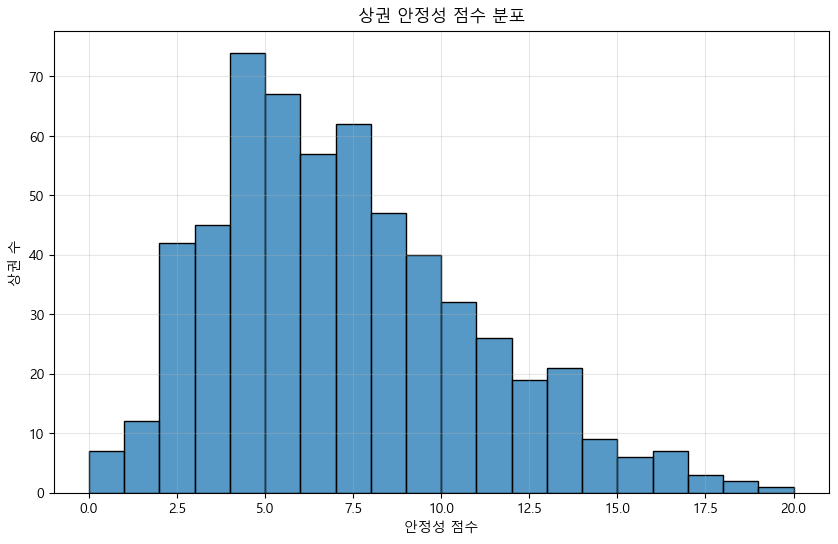

In [66]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='안정성_점수', bins=20)

# 그래프 제목과 축 레이블 설정
plt.title('상권 안정성 점수 분포')
plt.xlabel('안정성 점수')
plt.ylabel('상권 수')

# 그리드 추가
plt.grid(True, alpha=0.3)

plt.show()